In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualizations
import seaborn as sns # More visualizations
import os # Deal with the file system
from tqdm.notebook import tqdm, trange # loader bar
import urllib.parse
from kaggle_datasets import KaggleDatasets # The images for this lab come from KaggleDataSets
import PIL # For saving images
import shutil # For zipping images to output file

import tensorflow as tf
import keras

# TFRecord image extraction
from tensorflow import string, cast, reshape, float32
from tensorflow.io.gfile import glob
from tensorflow.io import FixedLenFeature, parse_single_example
from tensorflow.image import decode_jpeg
from tensorflow.data import TFRecordDataset, Dataset

# Model building
from tensorflow import random_normal_initializer, GradientTape, ones_like, zeros_like, reduce_mean, abs
from keras.initializers import RandomNormal
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Concatenate, ZeroPadding2D
from keras.losses import BinaryCrossentropy
from tensorflow.compat.v1.losses import Reduction
from keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization

INPUT_DIR = "/kaggle/input/gan-monet"
WORKING_DIR = "/kaggle/working"
RANDOM_STATE = 1 # Set to None if reproducibility is not needed
DEBUG_SAMPLE_FRAC = 1 # Reduce the amount of data used so that debugging the notebook is faster

# Set up TPU usage
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Number of replicas: 1
2.11.0


# Brief Introduction to the Problem and the Data
This competition is an exciting foray into the world of AI art generation.  

## The Problem 
Given a set of images to draw inspiration from, train an AI model to generate images that are as indiscernable from images in that set as can be managed. 

In fact, with the approach of a generative adversarial network, a discriminator network will also be trained to learn which images which belong in the set and will be coupled with the generator.  This way, as the discriminator gets better at discerning if an image belongs in the set, the generator gets better at making images that look like they belong in that same set.

With the trained generator, generate 7K to 10K Monet style images.

## The Data
The data is comprised of two sets of images: Monet paintings and source photos.  Each set is offered in two different image formats: JPEG and TFRecord. The images are 256x256 pixels

The paintings will be used to train the discriminator, and the photos will be used as inspiration for the generator.

For this approach, the TFRecord versions of the images will be used.  

The generated images will be bundled in images.zip and each generated image will be 256x256 pixels.

# Exploratory Data Analysis
The image data is loaded from the image source.  The Monet painting images will be loaded separately from the photographs.  

First, the image filenames are loaded

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


A routine is defined to load the image data from a TFRecord, and a method that will then use the first routine to extract image data from a list of filenames.

In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = decode_jpeg(image, channels=3)
    image = (cast(image, float32) / 127.5) - 1 # Center the image pixel value on zero (-1 <= px <= 1)
    image = reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_tfrecord(example):
    tfrecord_format = {
        "image_name": FixedLenFeature([], string),
        "image": FixedLenFeature([], string),
        "target": FixedLenFeature([], string)
    }
    example = parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


def load_dataset(filenames, labeled=True, ordered=False):
    dataset = TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Next, the datasets are loaded into TFRecordDatasets

In [4]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

An example is selected from each dataset to render and observe.

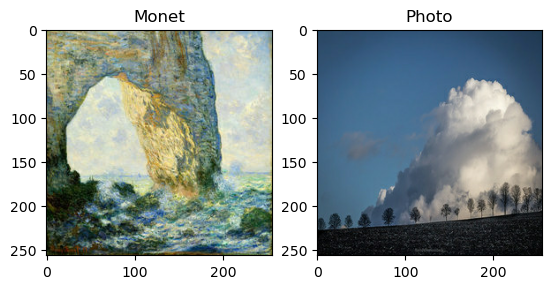

In [5]:
example_monet = next(iter(monet_ds))
plt.subplot(1, 2, 1)
plt.title("Monet")
plt.imshow(example_monet[0]*0.5 + 0.5) # Restore pixel value to 0 - 1

example_photo = next(iter(photo_ds))
plt.subplot(1, 2, 2)
plt.title("Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5) # Restore pixel value to 0 - 1

# Model Architecture
In order to generate convincing Monet art, the data model will train as a Generative Adversarial Network, where a generator is trained to trick a discriminator as the discriminator is trained to identify originals from generated output.

Since the input dataset offers source photos that we can translate to a Monet style, a CycleGAN architecture can be used with great effect.  CycleGANs are good for translating images from one domain to another, such as translating photo from photorealistic style to a Monet art style.

Additionally, the GAN will be designed with a UNET architecture.  A UNET design has a contracting path and an expansive path. The contracting path is responsible for extracting features from the input image, while the expansive path is responsible for upsampling the features and reconstructing the output image.

The TFRecord image type is selected and routines defined above load image data from the input set.  Loss functions for different types of translations will be built and will allow comparing output of the discriminator and the generator with original, generated, cycled, and same images. 

The model will then be compiled using an Adam optimizer, which is a popular choice to tune hyperparameters during the model fit phase.

## UNET Downsampler and Upsampler
The first path of the UNET downsamples the input image using CNNs with a stride of 2, which will reduce the width and height by 2 each pass.  The downsample routine is defined as below.

In [6]:
def downsample(num_filters, kernel_size, apply_instancenorm=True):
    normal_init = random_normal_initializer(0, 0.02)
    gamma_init = RandomNormal(mean=0, stddev=0.02)

    # Build the model for the downsampler
    model = Sequential()
    model.add(Conv2D(num_filters, kernel_size, strides=2, padding='same', kernel_initializer=normal_init, use_bias=False))

    if apply_instancenorm:
        model.add(InstanceNormalization(gamma_initializer=gamma_init))

    model.add(LeakyReLU())

    return model

The second path of the UNET architecture upsamples input using Conv2DTranspose, which in effect does the opposite of a Conv2D layer.

In [7]:
def upsample(num_filters, kernel_size, apply_dropout=False):
    normal_init = random_normal_initializer(0, 0.02)
    gamma_init = RandomNormal(mean=0, stddev=0.02)

    model = Sequential()
    model.add(Conv2DTranspose(num_filters, kernel_size, strides=2, padding='same', kernel_initializer=normal_init, use_bias=False))
    model.add(InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        model.add(Dropout(0.5))

    model.add(ReLU())

    return model

## Build the Generator
The two paths of downsampling and upsampling are combined to build the generator.  As a UNET architecture, the generator first downsamples the image and then upsamples the result of the downsamples.  Because of how the downsampler and upsampler connect, the generator can remember long-range dependencies through the image processing layers.

In [8]:
def Generator():
    inputs = Input(shape=[256, 256, 3])
    
    u_down = [
        downsample(64, 4, apply_instancenorm=False), # After this, image size is 128
        downsample(128, 4), # After this, image size is 64
        downsample(256, 4), # After this, image size is 32
        downsample(512, 4), # After this, image size is 16
        downsample(512, 4), # After this, image size is 8
        downsample(512, 4), # After this, image size is 4
        downsample(512, 4), # After this, image size is 2
        downsample(512, 4), # After this, image size is 1
    ]
    
    u_up = [
        upsample(512, 4, apply_dropout=True), # After this, image size is 2
        upsample(512, 4, apply_dropout=True), # After this, image size is 4
        upsample(512, 4, apply_dropout=True), # After this, image size is 8
        upsample(512, 4), # After this, image size is 16
        upsample(256, 4), # After this, image size is 32
        upsample(128, 4), # After this, image size is 64
        upsample(64, 4), # After this, image size is 128
    ]
    
    normal_init = random_normal_initializer(0, 0.02)
    final = Conv2DTranspose(3, 4, strides=2, padding="same", kernel_initializer=normal_init, activation='tanh') #  After this, image size is 128

    # Build UNET Neural Network layers
    x = inputs
    
    # Downsample
    skips = []
    for down in u_down:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    # Upsample and keep the skip connections
    for up, skip in zip(u_up, skips):
        x = up(x)
        x = Concatenate()([x, skip])
        
    x = final(x)
    
    return Model(inputs=inputs, outputs=x)

## Build the Discriminator
The discriminator classifies the input as fake (generated) or real.  The output of this discriminator is a small 2D image with high pixel values indicating real and low pixel values indicating fake classification.

In [9]:
def Discriminator():
    normal_init = random_normal_initializer(0, 0.02)
    gamma_init = RandomNormal(mean=0, stddev=0.02)
    
    inputs = Input(shape=[256, 256, 3], name="input_image")
    
    x = inputs
    
    x = downsample(64, 4, apply_instancenorm=False)(x) # After this, image size is 128
    x = downsample(128, 4)(x) # After this, image size is 64
    x = downsample(256, 4)(x) # After this, image size is 32
    
    x = ZeroPadding2D()(x) # After this, image size is 34
    x = Conv2D(512, 4, strides=1, kernel_initializer=normal_init, use_bias=False)(x) # After this, image size is 31
    x = InstanceNormalization(gamma_initializer=gamma_init)(x) # After this, image size is 31
    x = LeakyReLU()(x) # After this, image size is 31
    x = ZeroPadding2D()(x) # After this, image size is 33
    x = Conv2D(1, 4, strides=1, kernel_initializer=normal_init)(x) # After this, image size is 30
    
    return Model(inputs=inputs, outputs=x)

## Collect the Generators and Discriminators
Within the scope of a strategy, the Generators and Discriminators for the Monet art and for the photographs are defined.

In [10]:
with strategy.scope():
    monet_gen = Generator()
    monet_dsc = Discriminator()
    
    photo_gen = Generator()
    photo_dsc = Discriminator()


With the generator not trained yet, the generated Monet does not yet look correct.

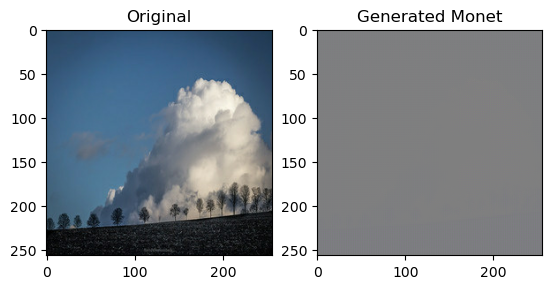

In [11]:
to_monet = monet_gen(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(example_photo[0]*0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Generated Monet")
plt.imshow(to_monet[0]*0.5 + 0.5)

plt.show()

## Build the Model
An implementation of a Model is defined for this GAN that will transform a photo into a Monet twice.  This twice transformed Monet will then be used to calculate similarity.

In [12]:
class CycleGAN(Model):
    def __init__(self, monet_gen, monet_dsc, photo_gen, photo_dsc, cycle=10):
        super(CycleGAN, self).__init__()
        
        self.monet_gen = monet_gen
        self.monet_dsc = monet_dsc
        
        self.photo_gen = photo_gen
        self.photo_dsc = photo_dsc
        
        self.cycle = cycle
        
    def compile(self, monet_gen_optimizer, monet_dsc_optimizer, photo_gen_optimzier, photo_dsc_optimizer, gen_loss_fn, dsc_loss_fn, cyc_loss_fn, idy_loss_fn):
        super(CycleGAN, self).compile()

        self.monet_gen_optimizer = monet_gen_optimizer
        self.monet_dsc_optimizer = monet_dsc_optimizer
        
        self.photo_gen_optimizer = photo_gen_optimizer
        self.photo_dsc_optimizer = photo_dsc_optimizer
        
        self.gen_loss_fn = gen_loss_fn
        self.dsc_loss_fn = dsc_loss_fn
        self.cyc_loss_fn = cyc_loss_fn
        self.idy_loss_fn = idy_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with GradientTape(persistent=True) as tape:
            
            # Photo --> Monet --> Photo
            faked_monet = self.monet_gen(real_photo, training=True)
            cycld_photo = self.photo_gen(faked_monet, training=True)
            
            # Monet --> Photo --> Monet
            faked_photo = self.photo_gen(real_monet, training=True)
            cycld_monet = self.monet_gen(faked_photo, training=True)
            
            # Generating itself
            same_monet = self.monet_gen(real_monet, training=True)
            same_photo = self.photo_gen(real_photo, training=True)
            
            # Discriminator used to check real images
            dsc_real_monet = self.monet_dsc(real_monet, training=True)
            dsc_real_photo = self.photo_dsc(real_photo, training=True)
            
            # Discriminator used to check fake images
            dsc_faked_monet = self.monet_dsc(faked_monet, training=True)
            dsc_faked_photo = self.photo_dsc(faked_photo, training=True)
            
            # Calculate generator loss
            monet_gen_loss = self.gen_loss_fn(dsc_faked_monet)
            photo_gen_loss = self.gen_loss_fn(dsc_faked_photo)
            
            # Calculate total cycle consistency loss
            tot_cycle_loss = self.cyc_loss_fn(real_monet, cycld_monet, self.cycle) + self.cyc_loss_fn(real_photo, cycld_photo, self.cycle)
            
            # Calculate total generator loss
            tot_monet_gen_loss = monet_gen_loss + tot_cycle_loss + self.idy_loss_fn(real_monet, same_monet, self.cycle)
            tot_photo_gen_loss = photo_gen_loss + tot_cycle_loss + self.idy_loss_fn(real_photo, same_photo, self.cycle)
            
            # Calculate discriminator loss
            monet_dsc_loss = self.dsc_loss_fn(dsc_real_monet, dsc_faked_monet)
            photo_dsc_loss = self.dsc_loss_fn(dsc_real_photo, dsc_faked_photo)
            
        # Calculate the gradients for the generator
        monet_gen_grads = tape.gradient(tot_monet_gen_loss, self.monet_gen.trainable_variables)
        photo_gen_grads = tape.gradient(tot_photo_gen_loss, self.photo_gen.trainable_variables)
        
        # Apply the gradients to the generator optimizer
        self.monet_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.monet_gen.trainable_variables))
        self.photo_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.photo_gen.trainable_variables))
        
        # Calculate the gradients for the discriminator
        monet_dsc_grads = tape.gradient(monet_dsc_loss, self.monet_dsc.trainable_variables)
        photo_dsc_grads = tape.gradient(photo_dsc_loss, self.photo_dsc.trainable_variables)
        
        # Apply the gradients to the discriminator optimizer
        self.monet_dsc_optimizer.apply_gradients(zip(monet_dsc_grads, self.monet_dsc.trainable_variables))
        self.photo_dsc_optimizer.apply_gradients(zip(photo_dsc_grads, self.photo_dsc.trainable_variables))
        
        return {
            "monet_gen_loss": tot_monet_gen_loss,
            "photo_gen_loss": tot_photo_gen_loss,
            "monet_dsc_loss": monet_dsc_loss,
            "photo_dsc_loss": photo_dsc_loss
        }       

## Define Loss Functions
The loss functions will calculate how accurately the generator and discriminator work.

### Discriminator Loss
The loss functions compare real images to a matrix of 1s and fake images to a matrix of 0s.  The perfect discriminator will output all 1s for real images and all 0s for afake images.  

With this approach in mind, the discriminator loss outputs the average of the real image loss and the generated image loss. 

In [13]:
with strategy.scope():
    def discriminator_loss(real_img, gen_img):
        real_loss = BinaryCrossentropy(from_logits=True, reduction=Reduction.NONE)(ones_like(real_img), real_img)
        gen_loss = BinaryCrossentropy(from_logits=True, reduction=Reduction.NONE)(zeros_like(gen_img), gen_img)
        
        tot_dsc_loss = real_loss + gen_loss
        
        return tot_dsc_loss * 0.5        

### Generator Loss
The loss function for the generator relies on the fact that the discriminator output will be only 1s.  So the loss function will compare the generated image to a matrix of ones.

In [14]:
with strategy.scope():
    def generator_loss(gen_img):
        return BinaryCrossentropy(from_logits=True, reduction=Reduction.NONE)(ones_like(gen_img), gen_img)

### Cycle Consistency Loss
When the original photo is transformed to a Monet art and back, the resulting image should be similar to the original image.  The loss function can so be implemented to return a multiple or fraction of the average of the difference between the original and resulting images.

In [15]:
with strategy.scope():
    def cycle_loss(real_img, cycld_img, LAMBDA):
        return LAMBDA * reduce_mean(abs(real_img - cycld_img))

### Identity Loss
Finally the identity loss function compares the image with it's own generator (i.e. photo with the photo generator and monet with monet generator).  The generator for each should ideally generate the same image as the original.

In [16]:
with strategy.scope():
    def identity_loss(real_img, same_img, LAMBDA):
        return LAMBDA * 0.5 * reduce_mean(abs(real_img - same_img))

## Train the Model
With the above implementations for generator, discriminator, and loss functions, the CycleGAN model can be trained.

In [17]:
with strategy.scope():
    monet_gen_optimizer = Adam(2e-4, beta_1=0.5)
    monet_dsc_optimizer = Adam(2e-4, beta_1=0.5)
    
    photo_gen_optimizer = Adam(2e-4, beta_1=0.5)
    photo_dsc_optimizer = Adam(2e-4, beta_1=0.5)

In [18]:
with strategy.scope():
    model = CycleGAN(monet_gen, monet_dsc, photo_gen, photo_dsc)
    
    model.compile(
        monet_gen_optimizer = monet_gen_optimizer, 
        monet_dsc_optimizer = monet_dsc_optimizer, 
        photo_gen_optimzier = photo_gen_optimizer, 
        photo_dsc_optimizer = photo_dsc_optimizer, 
        gen_loss_fn = generator_loss, 
        dsc_loss_fn = discriminator_loss, 
        cyc_loss_fn = cycle_loss, 
        idy_loss_fn = identity_loss
    )

In [19]:
model.fit(Dataset.zip((monet_ds, photo_ds)), epochs=12, verbose=2)

Epoch 1/12


2023-05-03 05:42:21.126161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 - 181s - monet_gen_loss: 2.6516 - photo_gen_loss: 2.8013 - monet_dsc_loss: 0.7074 - photo_dsc_loss: 0.6062 - 181s/epoch - 603ms/step
Epoch 2/12
300/300 - 137s - monet_gen_loss: 2.8273 - photo_gen_loss: 2.9066 - monet_dsc_loss: 0.5969 - photo_dsc_loss: 0.5266 - 137s/epoch - 457ms/step
Epoch 3/12
300/300 - 137s - monet_gen_loss: 2.7527 - photo_gen_loss: 2.9500 - monet_dsc_loss: 0.6332 - photo_dsc_loss: 0.4487 - 137s/epoch - 457ms/step
Epoch 4/12
300/300 - 137s - monet_gen_loss: 2.7601 - photo_gen_loss: 2.8762 - monet_dsc_loss: 0.6333 - photo_dsc_loss: 0.4481 - 137s/epoch - 457ms/step
Epoch 5/12
300/300 - 137s - monet_gen_loss: 3.0014 - photo_gen_loss: 3.0906 - monet_dsc_loss: 0.5445 - photo_dsc_loss: 0.4545 - 137s/epoch - 458ms/step
Epoch 6/12
300/300 - 137s - monet_gen_loss: 2.9241 - photo_gen_loss: 2.8230 - monet_dsc_loss: 0.5046 - photo_dsc_loss: 0.4607 - 137s/epoch - 457ms/step
Epoch 7/12
300/300 - 137s - monet_gen_loss: 2.7530 - photo_gen_loss: 2.8121 - monet_dsc_loss: 0.511

# Results and Analysis
With the CycleGAN built, compiled, and fit, images may now be translated via the prepared model.  Here follow some example translations of a source photo to a monet style.

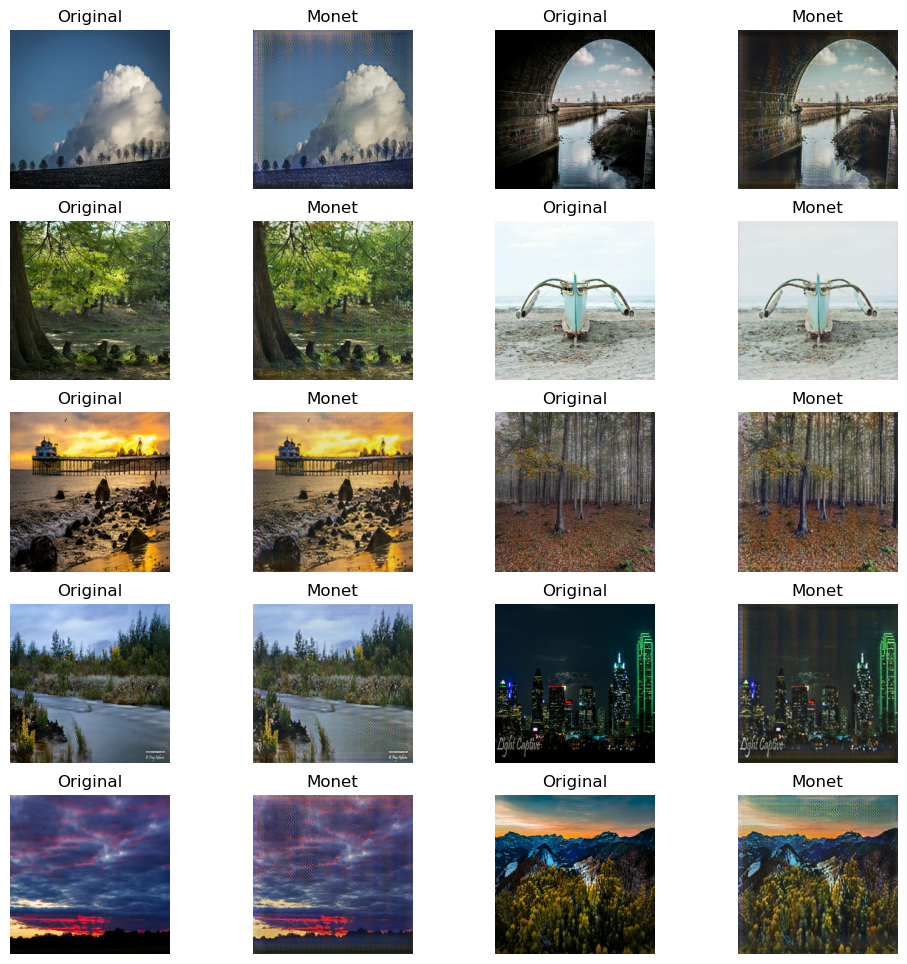

In [20]:
_, ax = plt.subplots(5, 4, figsize=(12, 12))

col = 0

# Arrange comparisons in a 4 column format
for i, img in enumerate(photo_ds.take(10)):
    pred = monet_gen(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)  # Scale the pixels up to rgb values
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8) # Scale the pixels up to rgb values
    
    ax[i//2, 2*col + 0].imshow(img)
    ax[i//2, 2*col + 0].set_title("Original")
    ax[i//2, 2*col + 0].axis("off")
    
    ax[i//2, 2*col + 1].imshow(pred)
    ax[i//2, 2*col + 1].set_title("Monet")
    ax[i//2, 2*col + 1].axis("off")
    
    col += 1
    if col == 2:
        col = 0
plt.show()

The Monet translations seem to match the original photos well, and yet also have applied a generative brush toward the Monet art style.  

## Create the submission file
With the model ready, the submission file containing 7K to 10K images translated to the Monet style may be preprared.

In [21]:
! mkdir "/kaggle/working/generated_images"

In [22]:
i = 1
for img in photo_ds:
    pred = monet_gen(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8) # Scale pixels up to the rgb values
    im = PIL.Image.fromarray(pred)
    im.save(f"{WORKING_DIR}/generated_images/gen_monet_{i}.jpg")
    if i%100 == 0:
        print(f"{i} images saved")
    i += 1

100 images saved
200 images saved
300 images saved
400 images saved
500 images saved
600 images saved
700 images saved
800 images saved
900 images saved
1000 images saved
1100 images saved
1200 images saved
1300 images saved
1400 images saved
1500 images saved
1600 images saved
1700 images saved
1800 images saved
1900 images saved
2000 images saved
2100 images saved
2200 images saved
2300 images saved
2400 images saved
2500 images saved
2600 images saved
2700 images saved
2800 images saved
2900 images saved
3000 images saved
3100 images saved
3200 images saved
3300 images saved
3400 images saved
3500 images saved
3600 images saved
3700 images saved
3800 images saved
3900 images saved
4000 images saved
4100 images saved
4200 images saved
4300 images saved
4400 images saved
4500 images saved
4600 images saved
4700 images saved
4800 images saved
4900 images saved
5000 images saved
5100 images saved
5200 images saved
5300 images saved
5400 images saved
5500 images saved
5600 images saved
5

In [23]:
shutil.make_archive(f"images", "zip", f"{WORKING_DIR}/generated_images")

'/kaggle/working/images.zip'

# Conclusion
The CycleGAN proved to be an effective model for translating photos to an art style.

This journal built and trained a CycleGAN model on several hundred Monet images and almost 1000 photo images. The goal of the model was to translate photos into the Monet art style. CycleGAN was selected as a good choice for image translations from one domain to another.

Along the way, several loss functions were defined to evaluate and fit the generator and discriminator. In the end, the model was fit over 25 epochs and the translations generated by the model looked quite convincing as part of the Monet art style.

Overall, we were successful in building and training a CycleGAN model that can translate photos into the Monet art style. The translations generated by the model are of high quality and are visually appealing. This model has the potential to be used for a variety of applications, such as creating art, generating images for marketing purposes, or even creating new art styles.

Thank you to Amy Jang, who offered a [tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) that guided this author's understanding.